In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
# import torch
# import time

In [3]:

def compute_cap_transmission(image, omega=0.95):
    image = image.astype(np.float32) / 255.0
    hsv = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    brightness = hsv[:, :, 2] / 255.0
    saturation = hsv[:, :, 1] / 255.0
    beta = np.max(brightness) + 1e-5
    transmission = 1 - omega * (beta - saturation)
    return np.clip(transmission, 0, 1)

def compute_dcp_transmission(image, omega=0.95, patch_size=15):
    image = image.astype(np.float32) / 255.0
    min_channel = np.min(image, axis=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (patch_size, patch_size))
    dark_channel = cv2.erode(min_channel, kernel)
    transmission = 1 - omega * dark_channel
    return np.clip(transmission, 0, 1)

def compute_haze_line_transmission(image, omega=0.95):
    image = image.astype(np.float32) / 255.0
    mean_intensity = np.mean(image, axis=2)
    beta = np.max(mean_intensity) + 1e-5
    transmission = 1 - omega * (beta - mean_intensity)
    return np.clip(transmission, 0, 1)

def create_guidance_image(image, omega=0.95, patch_size=15):
    cap_transmission = compute_cap_transmission(image, omega)
    dcp_transmission = compute_dcp_transmission(image, omega, patch_size)
    haze_line_transmission = compute_haze_line_transmission(image, omega)
    guidance_image = (cap_transmission + dcp_transmission + haze_line_transmission) / 3.0
    return guidance_image

## Utility Functions

In [4]:
def getStructuringElement(shape, ksize):
    if shape == 0:  
        return np.ones(ksize, dtype=np.uint8)

def erode(image, kernel):
    """Erosion operation using custom structuring element."""
    """Grayscale input image and binary kernel."""
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2
    
    # Pad the image to handle border effects
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=255)
    eroded_image = np.zeros_like(image)

    # Perform erosion: Removes small structures, refines edges
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+k_h, j:j+k_w]
            # The kernel slides across the image, and the pixel value under the anchor point is replaced with the minimal pixel value overlapped by the kernel. 
            eroded_image[i, j] = np.min(region[kernel == 1])  # Apply erosion
    
    return eroded_image

## Dark Channel

In [5]:
def dark_channel(img, size=15):
    """Computes the dark channel of an image."""
    min_channel = np.min(img, axis=2)  # Find the minimum across color channels
    kernel = getStructuringElement(0, (size, size))  # Custom structuring element
    dark = erode(min_channel, kernel)  # Custom erosion function
    return dark

## Atmospheric Light

In [6]:
def atmospheric_light(img, dark):
    """Estimates the atmospheric light by finding the brightest pixels in the dark channel."""
    h, w = img.shape[:2]
    num_pixels = h * w // 1000  # Take top 0.1% brightest pixels
    dark_vec = dark.reshape(h * w)
    img_vec = img.reshape(h * w, 3)
    indices = np.argsort(dark_vec)[-num_pixels:]  # Get indices of top pixels
    atmo_light = np.mean(img_vec[indices], axis=0)  # Compute mean of brightest pixels
    return atmo_light

## Transmission Estimate

In [7]:
def transmission_estimate(img, atmo_light, omega=0.95, size=15):
    """Estimates the transmission map."""
    norm_img = img / atmo_light
    transmission = 1 - omega * dark_channel(norm_img, size)
    return transmission

## Recover Image

In [8]:
def recover_image(img, t, atmo_light, t0=0.1):
    """Recovers the haze-free image using the estimated transmission map."""
    t = np.maximum(t, t0)  # Avoid division by zero
    J = (img - atmo_light) / t[:, :, None] + atmo_light
    return np.clip(J, 0, 1)

def guided_filter(I, p, r, eps):
    """Guided filter for refining the transmission map."""
    mean_I = cv2.boxFilter(I, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    corr_I = cv2.boxFilter(I * I, cv2.CV_64F, (r, r))
    corr_Ip = cv2.boxFilter(I * p, cv2.CV_64F, (r, r))

    var_I = corr_I - mean_I * mean_I
    cov_Ip = corr_Ip - mean_I * mean_p

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    q = mean_a * I + mean_b
    return q

def dehaze(img_path):
    """Complete dehazing pipeline using Dark Channel Prior."""
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image at path {img_path} could not be loaded.")
    img = img / 255.0  # Normalize image

    dark = dark_channel(img)
    atmo_light = atmospheric_light(img, dark)
    transmission = transmission_estimate(img, atmo_light)
    
    # Refining transmission map using guided filter
    gray_img = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    if gray_img is None:
        raise ValueError("Conversion to grayscale failed.")
    gray_img = gray_img / 255.0
    
    refined_t = guided_filter(gray_img, transmission, r=60, eps=1e-3)
    
    dehazed_img = recover_image(img, refined_t, atmo_light)
    return (dehazed_img * 255).astype(np.uint8)

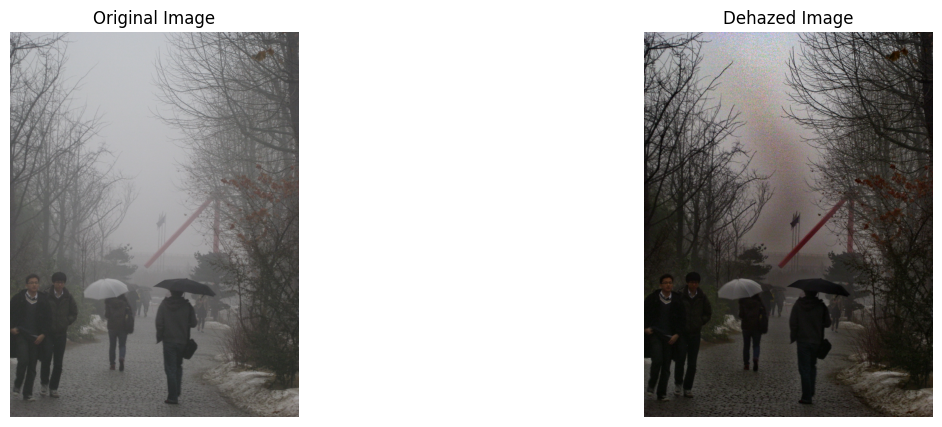

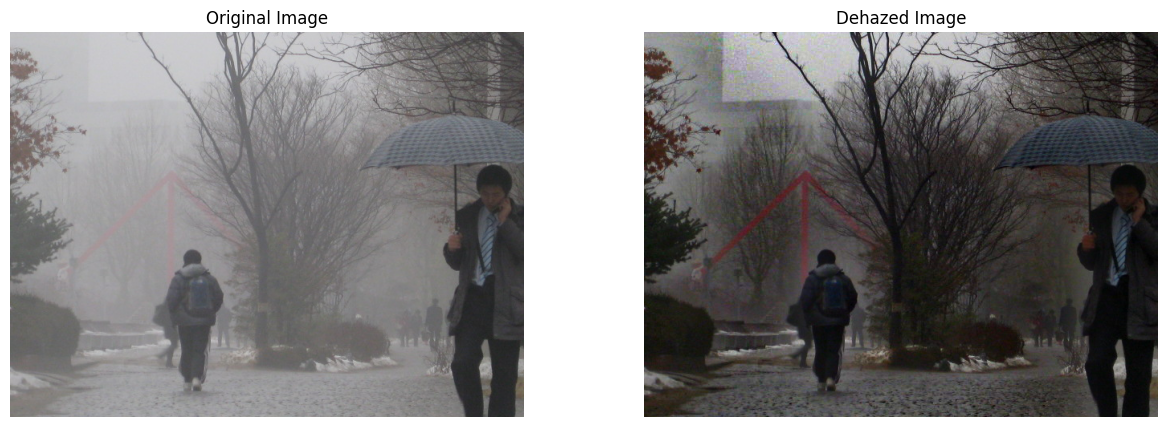

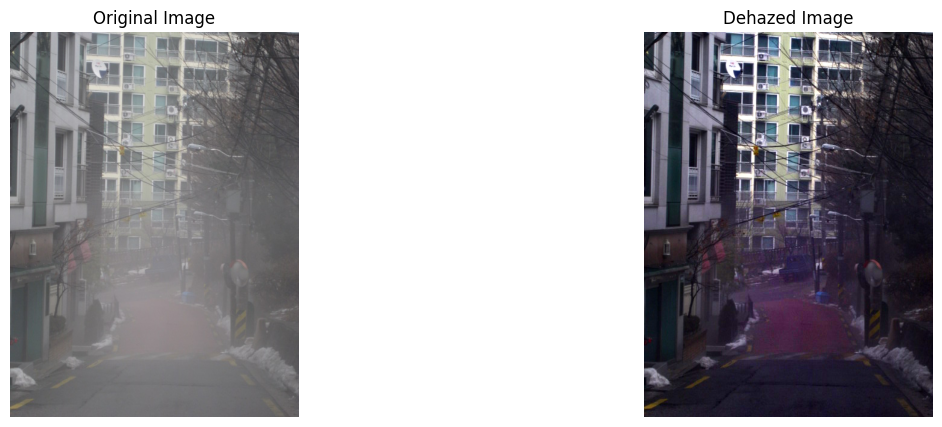

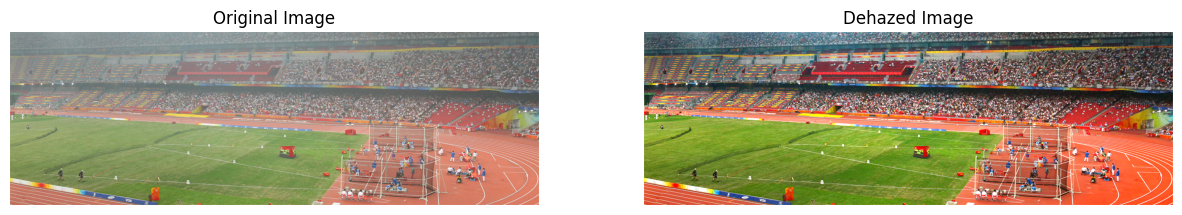

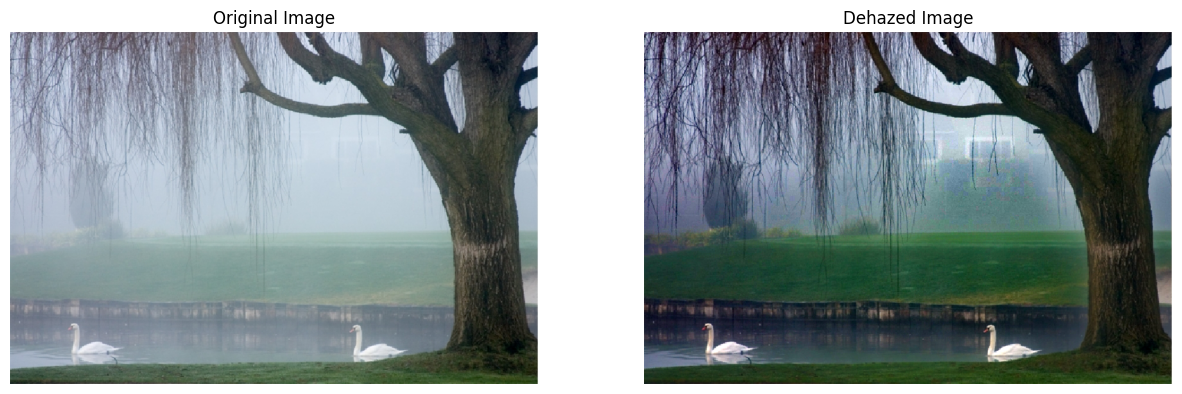

In [9]:
image_paths = ["dataset/base/train/St_Wf_D_L__033.JPG"
    , "dataset/base/train/St_Wf_D_L__029.JPG"
    , "dataset/base/train/St_Wf_D_L__009.JPG"
    , "dataset/base/test/91.jpg"
    , "dataset/base/test/92.jpg"]
for image_path in image_paths:
    dehazed_img = dehaze(image_path)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    image = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(dehazed_img, cv2.COLOR_BGR2RGB))
    plt.title('Dehazed Image')
    plt.axis('off')

    plt.show()


# Process and Store Images

In [10]:
from tqdm import tqdm

def dehaze_image(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    image_files = [f for f in os.listdir(input_dir) if f.endswith(".JPG") or f.endswith(".jpg")]
    
    for filename in tqdm(image_files, desc="Dehazing Images"):
        image_path = os.path.join(input_dir, filename)
        dehazed_image = dehaze(image_path)
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, dehazed_image)
        print(f"Processed and saved: {output_path}")

In [11]:
import torch
import torch.nn.functional as F

class FeatureLossNetwork(torch.nn.Module):
    def __init__(self, feature_extractor):
        super(FeatureLossNetwork, self).__init__()
        self.feature_layers = feature_extractor
        self.layer_name_mapping = {
            '2': "conv1_2",
            '8': "conv2_2",
            '15': "conv3_3"
        }

    def extract_features(self, x):
        output = {}
        for name, module in self.feature_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return list(output.values())

    def forward(self, predicted, ground_truth):
        loss = []
        predicted_features = self.extract_features(predicted)
        ground_truth_features = self.extract_features(ground_truth)
        for pred_feature, gt_feature in zip(predicted_features, ground_truth_features):
            loss.append(F.mse_loss(pred_feature, gt_feature))

        return sum(loss) / len(loss)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..69758426].


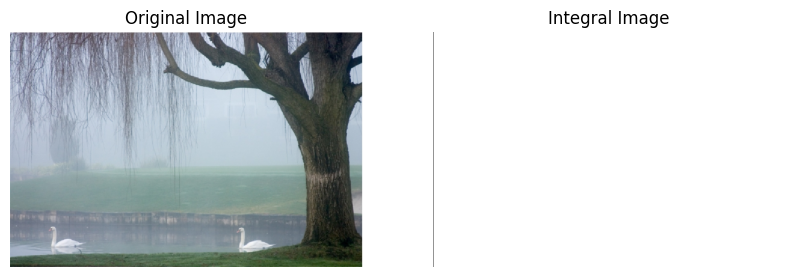

In [12]:
# Compute the integral image
integral_image = cv2.integral(image)

# Visualize the integral image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(integral_image, cmap='gray')
plt.title('Integral Image')
plt.axis('off')

plt.show()

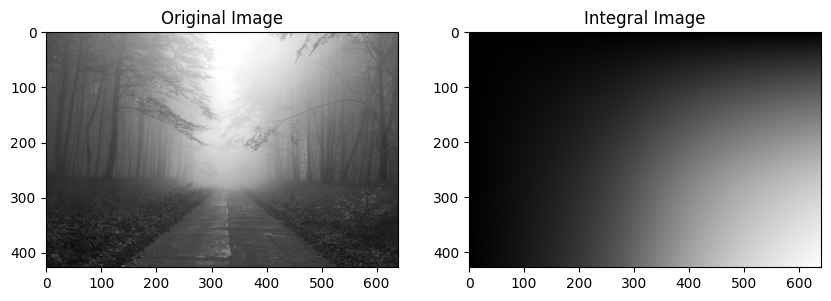

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
image = cv2.imread('dataset/autumn.jpg', cv2.IMREAD_GRAYSCALE)

# Compute the integral image
integral_image = cv2.integral(image)

# Normalize the integral image for visualization
integral_image_normalized = cv2.normalize(integral_image, None, 0, 255, cv2.NORM_MINMAX)
integral_image_normalized = integral_image_normalized.astype(np.uint8)

# Display the original and integral images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Integral Image')
plt.imshow(integral_image_normalized, cmap='gray')
plt.show()


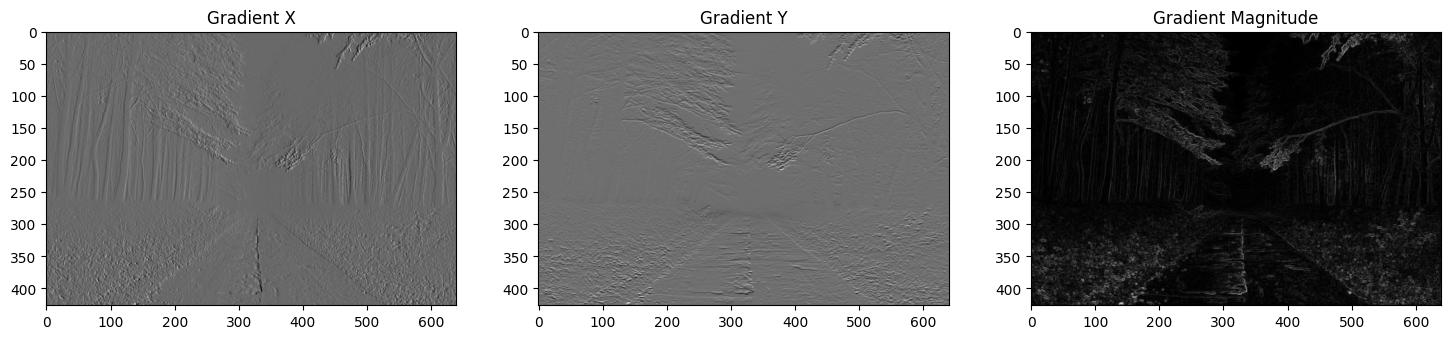

In [ ]:
# Compute the Sobel gradients
grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

# Compute the gradient magnitude
gradient_magnitude = cv2.magnitude(grad_x, grad_y)

# Display the gradients and gradient magnitude
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Gradient X')
plt.imshow(grad_x, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Gradient Y')
plt.imshow(grad_y, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Gradient Magnitude')
plt.imshow(gradient_magnitude, cmap='gray')

plt.show()


In [1]:
import cv2
import numpy as np

def dark_channel_prior(image, size=15):
    """Compute the dark channel prior of the image."""
    min_channel = np.amin(image, axis=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    dark_channel = cv2.erode(min_channel, kernel)
    return dark_channel

def atmospheric_light(image, dark_channel):
    """Estimate the atmospheric light in the image."""
    flat_image = image.reshape(-1, 3)
    flat_dark = dark_channel.ravel()
    search_idx = (-flat_dark).argsort()[:int(0.001 * len(flat_dark))]
    A = np.mean(flat_image[search_idx], axis=0)
    return A

def transmission_map(image, A, omega=0.95, size=15):
    """Estimate the transmission map of the image."""
    norm_image = image / A
    dark_channel = dark_channel_prior(norm_image, size)
    transmission = 1 - omega * dark_channel
    return transmission

def refine_transmission(image, transmission, lambda_=0.1):
    """Refine the transmission map using guided filtering."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.0
    refined_transmission = cv2.ximgproc.guidedFilter(guide=gray.astype(np.float32),
                                                    src=transmission.astype(np.float32),
                                                    radius=60,
                                                    eps=lambda_)
    return refined_transmission

def recover_image(image, transmission, A, t0=0.1):
    """Recover the dehazed image."""
    transmission = np.maximum(transmission, t0)
    J = (image - A) / transmission[:, :, np.newaxis] + A
    return np.clip(J, 0, 1)

def dehaze_image(image_path):
    """Main function to dehaze the image."""
    image = cv2.imread(image_path).astype(np.float32) / 255.0

    # Step 1: Compute the dark channel prior
    dark_channel = dark_channel_prior(image)

    # Step 2: Estimate atmospheric light
    A = atmospheric_light(image, dark_channel)

    # Step 3: Estimate initial transmission map
    transmission = transmission_map(image, A)

    # Step 4: Identify densely hazed regions (e.g., sky) and adjust transmission
    # Here, we use a simple thresholding method to identify bright regions
    # You can replace this with a more sophisticated sky segmentation method
    dense_haze_mask = np.mean(image, axis=2) > 0.8  # Adjust threshold as needed
    transmission[dense_haze_mask] *= 0.5  # Apply higher scaling factor to dense haze regions

    # Step 5: Refine the transmission map
    refined_transmission = refine_transmission(image, transmission)

    # Step 6: Recover the dehazed image
    dehazed_image = recover_image(image, refined_transmission, A)

    # Convert back to 8-bit image
    dehazed_image = (dehazed_image * 255).astype(np.uint8)

    return dehazed_image

# Example usage
image_paths = ["dataset/base/train/St_Wf_D_L__033.JPG"
    , "dataset/base/train/St_Wf_D_L__029.JPG"
    , "dataset/base/train/St_Wf_D_L__009.JPG"
    , "dataset/base/test/91.jpg"
    , "dataset/base/test/92.jpg"]
for image_path in image_paths:
    dehazed = dehaze_image(image_path)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    image = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(dehazed, cv2.COLOR_BGR2RGB))
    plt.title('Dehazed Image')
    plt.axis('off')
    plt.show()


AttributeError: module 'cv2.ximgproc' has no attribute 'guidedFilter'

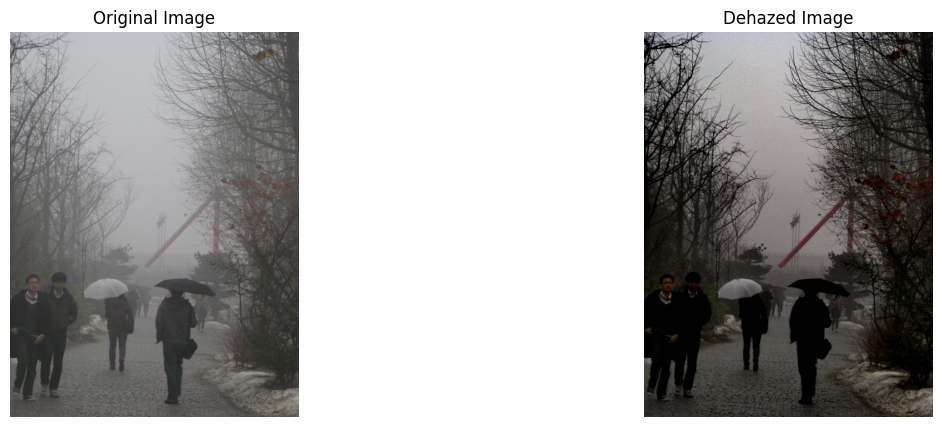

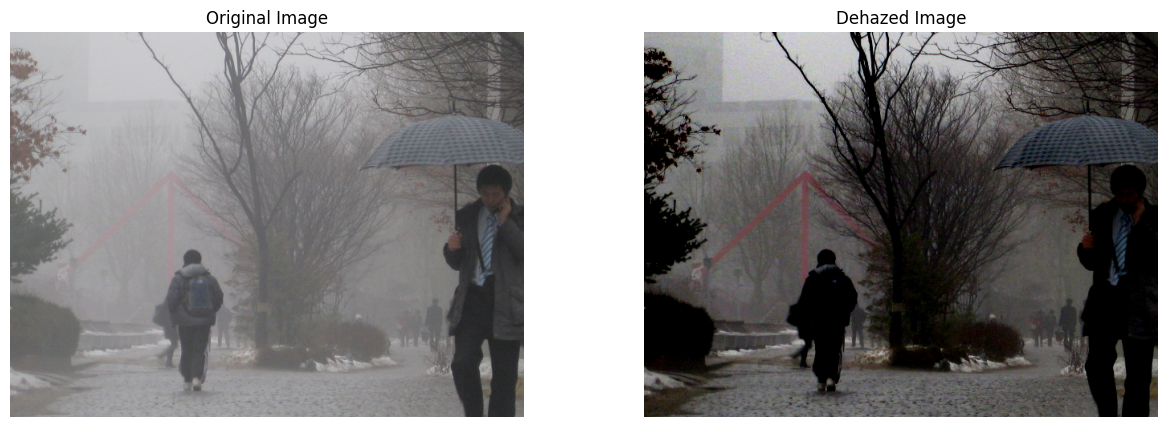

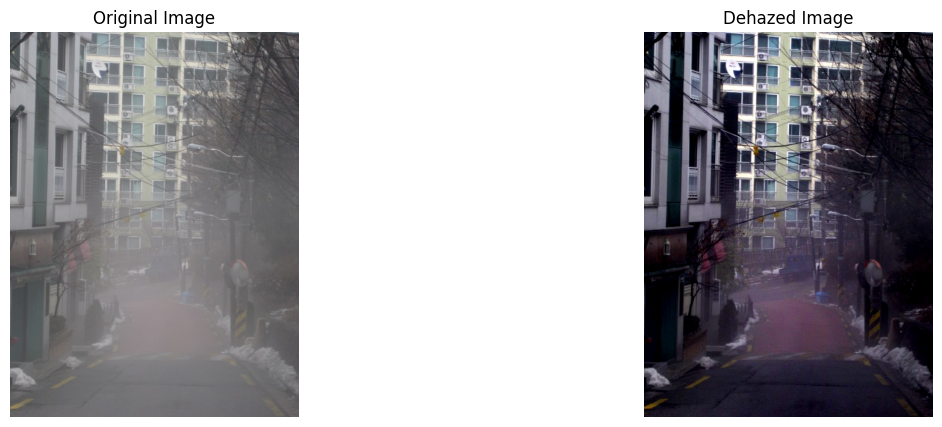

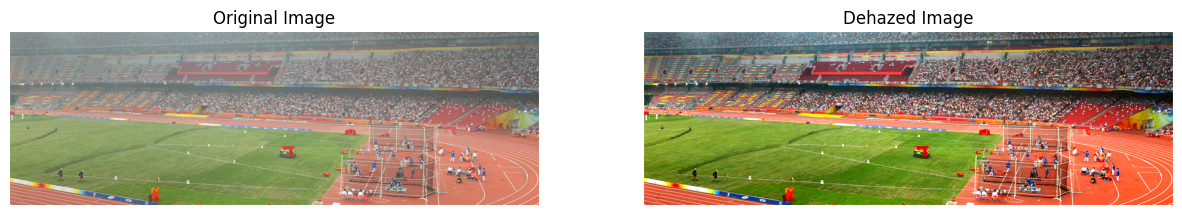

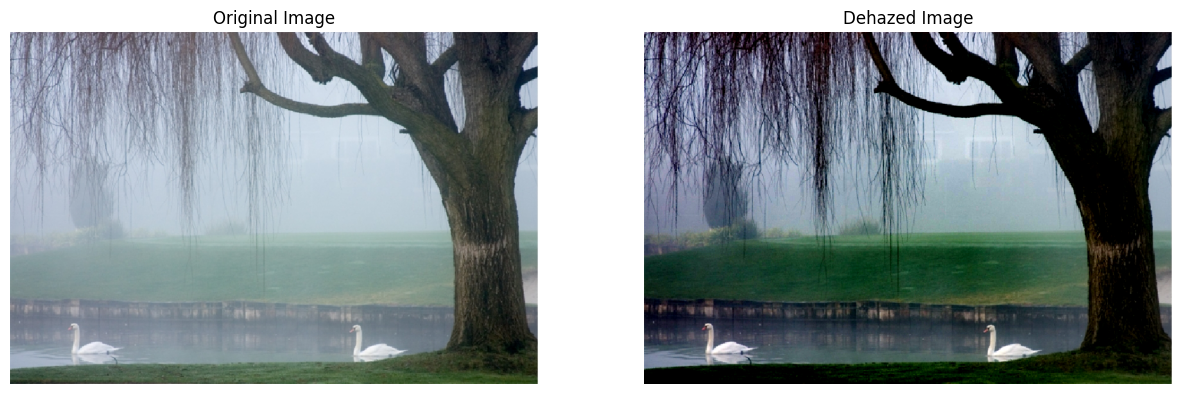

In [16]:
import numpy as np
import cv2

def guided_filter(I, p, r, eps):
    """
    Perform guided filtering.

    Parameters:
    I   - guidance image (grayscale)
    p   - input image to be filtered (grayscale)
    r   - radius of the guided filter
    eps - regularization parameter

    Returns:
    q   - filtered image
    """
    I = I.astype(np.float32)
    p = p.astype(np.float32)

    mean_I = cv2.boxFilter(I, cv2.CV_32F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_32F, (r, r))
    mean_Ip = cv2.boxFilter(I * p, cv2.CV_32F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(I * I, cv2.CV_32F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_32F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_32F, (r, r))

    q = mean_a * I + mean_b
    return q

def dark_channel(image, size=15):
    """
    Compute the dark channel of the image.

    Parameters:
    image - input RGB image
    size  - size of the patch

    Returns:
    dark_channel - dark channel of the image
    """
    min_img = np.min(image, axis=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    dark_channel = cv2.erode(min_img, kernel)
    return dark_channel

def estimate_atmospheric_light(image, dark_channel):
    """
    Estimate the atmospheric light in the image.

    Parameters:
    image        - input RGB image
    dark_channel - dark channel of the image

    Returns:
    A            - atmospheric light
    """
    flat_image = image.reshape(-1, 3)
    flat_dark = dark_channel.ravel()
    search_idx = (-flat_dark).argsort()[:int(0.001 * len(flat_dark))]
    A = np.mean(flat_image[search_idx], axis=0)
    return A

def estimate_transmission(image, A, omega=0.95, size=15):
    """
    Estimate the transmission map of the image.

    Parameters:
    image - input RGB image
    A     - atmospheric light
    omega - parameter to control the amount of haze removed
    size  - size of the patch

    Returns:
    transmission - estimated transmission map
    """
    norm_image = image / A
    dark_channel_img = dark_channel(norm_image, size)
    transmission = 1 - omega * dark_channel_img
    return transmission

def dehaze(image, omega=0.95, t0=0.1, r=205, eps=0.5):
    """
    Perform dehazing on the input image.

    Parameters:
    image - input RGB image
    omega - parameter to control the amount of haze removed
    t0    - threshold for transmission map
    r     - radius for guided filter
    eps   - regularization parameter for guided filter

    Returns:
    J     - dehazed image
    """
    image = image.astype(np.float32) / 255.0
    dark = dark_channel(image)
    A = estimate_atmospheric_light(image, dark)
    raw_transmission = estimate_transmission(image, A, omega)

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    refined_transmission = guided_filter(gray, raw_transmission, r, eps)

    transmission = np.maximum(refined_transmission, t0)
    J = (image - A) / transmission[:, :, np.newaxis] + A
    J = np.clip(J, 0, 1)
    return (J * 255).astype(np.uint8)

image_paths = ["dataset/base/train/St_Wf_D_L__033.JPG"
    , "dataset/base/train/St_Wf_D_L__029.JPG"
    , "dataset/base/train/St_Wf_D_L__009.JPG"
    , "dataset/base/test/91.jpg"
    , "dataset/base/test/92.jpg"]
for image_path in image_paths:
    dehazed = dehaze(cv2.imread(image_path))
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    image = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(dehazed, cv2.COLOR_BGR2RGB))
    plt.title('Dehazed Image')
    plt.axis('off')
    plt.show()


In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider

def guided_filter(I, p, r, eps):
    """
    Guided filter implementation based on He et al.'s method.
    """
    I = I.astype(np.float32)
    p = p.astype(np.float32)
    mean_I = cv2.boxFilter(I, -1, (r, r))
    mean_p = cv2.boxFilter(p, -1, (r, r))
    corr_I = cv2.boxFilter(I * I, -1, (r, r))
    corr_Ip = cv2.boxFilter(I * p, -1, (r, r))
    var_I = corr_I - mean_I * mean_I
    cov_Ip = corr_Ip - mean_I * mean_p
    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I
    mean_a = cv2.boxFilter(a, -1, (r, r))
    mean_b = cv2.boxFilter(b, -1, (r, r))
    q = mean_a * I + mean_b
    return q

def dark_channel(img, size=15):
    """
    Compute the dark channel prior.
    """
    min_channel = np.min(img, axis=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    return cv2.erode(min_channel, kernel)

def atmospheric_light(img, dark_channel):
    """
    Estimate atmospheric light using the brightest pixels in the dark channel.
    """
    h, w = img.shape[:2]
    num_pixels = int(0.001 * h * w)
    dark_vec = dark_channel.reshape(-1)
    img_vec = img.reshape(-1, 3)
    indices = np.argsort(dark_vec)[-num_pixels:]
    return np.mean(img_vec[indices], axis=0)

def transmission_map(img, A, omega=0.95, size=15):
    """
    Compute the initial transmission map.
    """
    norm_img = img / A
    return 1 - omega * dark_channel(norm_img, size)

def recover_image(img, t, A, t0=0.1):
    """
    Recover the dehazed image.
    """
    t = np.maximum(t, t0)
    return np.clip((img - A) / t[:, :, np.newaxis] + A, 0, 1)

def dehaze(image_path, r, eps, size, omega):
    img = cv2.imread(image_path) / 255.0
    dark = dark_channel(img)
    A = atmospheric_light(img, dark)
    t = transmission_map(img, A, omega, size)
    gray = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2GRAY)
    t_refined = guided_filter(gray, t, r, eps)
    result = recover_image(img, t_refined, A)
    
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Hazy Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(t_refined, cmap='gray')
    plt.title("Refined Transmission Map")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(result)
    plt.title("Dehazed Image")
    plt.axis("off")
    
    plt.show()

image_path = "dataset/base/train/St_Wf_D_L__033.JPG"  # Change to your image path

interact(dehaze, 
         image_path=[image_path,
                      "dataset/base/train/St_Wf_D_L__029.JPG"
                    , "dataset/base/train/St_Wf_D_L__009.JPG"
                    , "dataset/base/test/91.jpg"
                    , "dataset/base/test/92.jpg"], 
         r=IntSlider(min=0, max=100, step=1, value=1), 
         eps=FloatSlider(min=0.0001, max=2, step=0.0001, value=0.89),
         size= IntSlider(min=1, max=30, step=1, value=25),
         omega= FloatSlider(min=0, max=1, step=0.01, value=0.95)
         );


interactive(children=(Dropdown(description='image_path', options=('dataset/base/train/St_Wf_D_L__033.JPG', 'da…